In [2]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import curve_fit
from datetime import datetime

In [3]:
# linearithmic function to fit to
def fitfunc(x, a, b, c,d,e):
    return a*np.log(b*x + c)-(d*x)+e

Text(0.5, 1.0, 'preliminary plot')

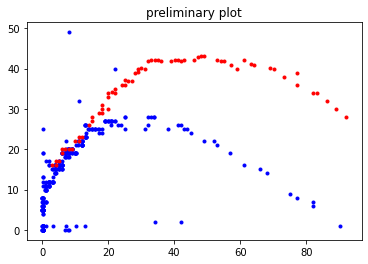

In [4]:
# load 2019 data into xs and ys
xs_2019 = []
ys_2019 = []
with open("2019_data.csv") as f:
    csv_reader = csv.reader(f, delimiter=",")
    a = []
    for idx, r in enumerate(csv_reader):
        if idx != 0:
            a.append(r)
    a = sorted(a, key= lambda x: float(x[0]))
    for idx, r in enumerate(a):
        xs_2019.append(float(r[0])/86400)
        ys_2019.append(float(r[1]))

# load 2020 data into nxs and nys
xs_2020 = []
ys_2020 = []
with open("2020_data.csv") as f:
    # first_r is timestamp for the first day of the app cycle (may 28, 9 am est)
    # AMCAS only started tweeting on may 31st
    first_r = 1590667200 
    csv_reader = csv.reader(f, delimiter=",")
    a = []
    for idx, r in enumerate(csv_reader):
        if idx != 0:
            a.append(r)
    a = sorted(a, key= lambda x: float(x[2]))
    for idx, r in enumerate(a):            
        xs_2020.append((float(r[2])-first_r)/86400)
        ys_2020.append((float(r[3])-float(r[2]))/86400)
xs_2019 = np.asarray(xs_2019)
ys_2019 = np.asarray(ys_2019)
xs_2020 = np.asarray(xs_2020)
ys_2020 = np.asarray(ys_2020)
plt.plot(xs_2019, ys_2019, 'b.', label="data")
plt.plot(xs_2020, ys_2020, 'r.', label="data")
plt.title("preliminary plot")

In [5]:
# Curvefit solver. Maxfev set to 1e6 to ensure some fit is found
popt2020, pcov2020 = curve_fit(fitfunc, np.array(xs_2020), np.array(ys_2020), maxfev=1000000)
popt2019, pcov2019 = curve_fit(fitfunc, np.array(xs_2019), np.array(ys_2019), method='lm')

Text(0.5, 1.0, '# of Days to Verification vs Submission Day')

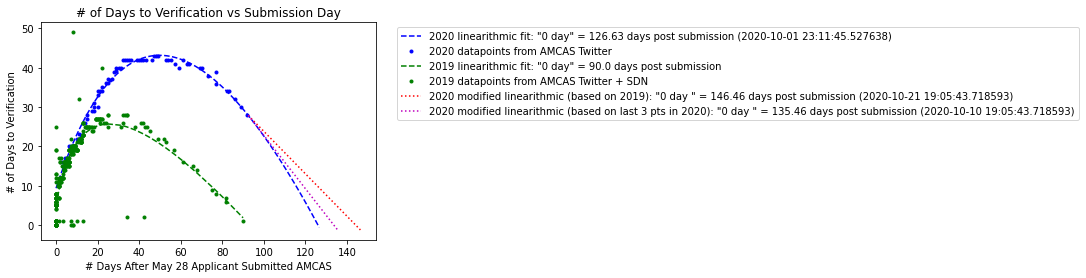

In [6]:
global_linspace = np.linspace(0, 200, 200)

# generate fitted line for 2020 data
fitted_2020ys = fitfunc(global_linspace, *popt2020)

# find x intercept for 2020 data first fit
xint_idx_2020 = -1

for idx, yval in enumerate(fitted_2020ys):
    if xint_idx_2020 == -1 and yval < 0:
        xint_idx_2020 = idx
        
# cut off the predicted fit at the x intercept        
fitted_2020ys = fitted_2020ys[0:xint_idx_2020+1]
fitted_2020xs = global_linspace[0:xint_idx_2020+1]

# store date for the predicted 2019 zeroday
xint_2019 = datetime.fromtimestamp(first_r + (global_linspace[xint_idx_2020])*86400)
# plot the predicted fit + 2020 data as a blue line
plt.plot(fitted_2020xs, fitted_2020ys, 'b--', 
         label=f"2020 linearithmic fit: \"0 day\" = {global_linspace[xint_idx_2020]:.2f} days post submission ({xint_2019})")
plt.plot(xs_2020, ys_2020, 'b.', label="2020 datapoints from AMCAS Twitter")

# generate fitted line for 2019 data
fitted_2019ys = fitfunc(xs_2019, *popt2019)

# plot 2019 data
plt.plot(xs_2019, fitted_2019ys, 'g--', 
         label=f"2019 linearithmic fit: \"0 day\" = {xs_2019[-1]} days post submission")
plt.plot(xs_2019, ys_2019, 'g.', label="2019 datapoints from AMCAS Twitter + SDN")

# find slope on downward portion of 2019 fit using last 2 pts (fix this to find deriviative!)
downslope_2019 = (fitted_2019ys[-2]-fitted_2019ys[-1])/(xs_2019[-2]-xs_2019[-1])
# find slope on downward portion over 3 most recent 2020 datapoints
downslope_2020 = (ys_2020[-3]-ys_2020[-1])/(xs_2020[-3]-xs_2020[-1])

# find last point on fitted line that closely matches last actual datapoint
value = xs_2020[-1]
closest_idx = np.abs(fitted_2020xs-value).argmin()

# create starting points for the downward slope projections
extended_2020_v1_xs = [fitted_2020xs[closest_idx]]
extended_2020_v1_ys = [fitted_2020ys[closest_idx]]
extended_2020_v2_xs = [fitted_2020xs[closest_idx]]
extended_2020_v2_ys = [fitted_2020ys[closest_idx]]

# create downward slope projections for 2019 and 2020
while extended_2020_v1_ys[-1] > -1:
    extended_2020_v1_xs.append(extended_2020_v1_xs[-1] + 1)
    extended_2020_v1_ys.append(extended_2020_v1_ys[-1] + downslope_2019)

while extended_2020_v2_ys[-1] > -1:
    extended_2020_v2_xs.append(extended_2020_v2_xs[-1] + 1)
    extended_2020_v2_ys.append(extended_2020_v2_ys[-1] + downslope_2020)

# find 0 day estimates
xint_2020_v1 = datetime.fromtimestamp(first_r + (extended_2020_v1_xs[-1])*86400)
xint_2020_v2 = datetime.fromtimestamp(first_r + (extended_2020_v2_xs[-1])*86400)

# plot out the downward slopes
plt.plot(extended_2020_v1_xs, extended_2020_v1_ys, 'r:', 
         label=f"2020 modified linearithmic (based on 2019): \"0 day \" = {extended_2020_v1_xs[-1]:.2f} days post submission ({xint_2020_v1})")
plt.plot(extended_2020_v2_xs, extended_2020_v2_ys, 'm:', 
         label=f"2020 modified linearithmic (based on last 3 pts in 2020): \"0 day \" = {extended_2020_v2_xs[-1]:.2f} days post submission ({xint_2020_v2})")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("# Days After May 28 Applicant Submitted AMCAS")
plt.ylabel("# of Days to Verification")
plt.title("# of Days to Verification vs Submission Day")
